<a href="https://colab.research.google.com/github/Mateusz-best-creator/SkimLit/blob/main/SkimLit_milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary liblaries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create some helper functions that are going to be useful later

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  results = {}
  results["accuracy_score"] = accuracy_score(y_true, y_pred)
  results["precision_score"], results["recall_score"], results["f1_score"], _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division="warn")
  return results

# Check if our function is working on some random samples
calculate_results([1,1,1, 0, 0,1,1,1,0], [0,1,1, 0, 1,1,1,1, 1])

{'accuracy_score': 0.6666666666666666,
 'precision_score': 0.6428571428571428,
 'recall_score': 0.6666666666666666,
 'f1_score': 0.6461538461538461}

In [3]:
from pathlib import Path

def save_model(model, model_name, log_path="/content/saved_models"):
  save_path = Path(log_path) / model_name
  model.save(save_path, save_format="tf")

def load_model(model_name, log_path="/content/saved_models"):
  full_path = Path(log_path) / model_name
  return tf.keras.models.load_model(full_path)

In [4]:
# Check if predictions are the same
def compare_predictions(model_1, model_2, data):
  preds_1 = model_1.predict(data)
  preds_2 = model_2.predict(data)
  if np.all(preds_1 == preds_2):
    print(f"We have correctly saved our model, predictions are the same.")
  else:
    print(f"Predictions are different we incorrectly saved our model.")
  assert np.all(preds_1 == preds_2)

In [5]:
import datetime

def create_early_stopping_callback(patience=10, monitor_value="val_accuracy"):
  return tf.keras.callbacks.EarlyStopping(monitor=monitor_value,
                                          patience=patience)

def create_tensorboard_callback(experiment_name, log_path="/content/tensorboard_callback"):
  tensorboard_path = Path(log_path) / experiment_name / datetime.datetime.now().strftime("run_%Y_%m_%d_%H_%M_%S")
  print(f"Saving tensorboard callback to: {tensorboard_path}")
  return tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

def create_modelcheckpoint_callback(experiment_name, checkpoints_dir, monitor_value="val_accuracy"):
    modelcheckpoint_dir = Path(checkpoints_dir) / experiment_name
    print(f"Saving model checkpoints to: {modelcheckpoint_dir}")
    return tf.keras.callbacks.ModelCheckpoint(filepath=modelcheckpoint_dir,
                                              monitor=monitor_value,
                                              save_best_only=True,
                                              save_weights_only=True)

# 09. Milestone Project 2: SkimLit 📄🔥
In the previous notebook (NLP fundamentals in TensorFlow), we went through some fundamental natural lanuage processing concepts. The main ones being tokenization (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k: RCT:https://arxiv.org/abs/1710.06071, https://arxiv.org/pdf/1612.05251.pdf.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.


In [7]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


**Note:** another name for the validation set is "dev" set.

## Getting the data from files

In [8]:
def read_file(filename):
  with open(filename) as f:
    return f.readlines()

In [9]:
filenames = ["pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt",
             "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt",
             "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"]

read_file(filenames[1])[:15]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [10]:
def preprocess_file(filename):
  """
  Using this function we are going to extract the most
  important informations from our files and atfer that
  use pandas data structures to make them more visual.

  The format of output array is going to be:

  [
    {
      "target": "CONCLUSIONS",
      "text": "Elevated MELD-XI scores are associated with poor outcomes among patients admitted with ADHF.",
      "number_line": 10,
      "total_lines": 12
    }
  ]
  """
  final_result = []
  sentences = ""
  lines = read_file(filename)
  for line in lines:
    if line.startswith("###"):
      sentences = ""
    elif line.isspace():
      single_sentences = sentences.splitlines()
      for line_idx, single_sentence in enumerate(single_sentences):
        target_text = single_sentence.split("\t")
        sentence_dictionary = {}
        sentence_dictionary["target"] = target_text[0]
        sentence_dictionary["text"] = target_text[1]
        sentence_dictionary["line_number"] = line_idx
        sentence_dictionary["total_lines"] = len(single_sentences) - 1
        # Add above dictionary to the output dictionary
        final_result.append(sentence_dictionary)

    else:
      sentences += line

  return final_result

In [11]:
preprocessed_train_set = preprocess_file(filenames[0])
preprocessed_valid_set = preprocess_file(filenames[1])
preprocessed_test_set = preprocess_file(filenames[2])

# Check if worked
preprocessed_train_set[:2], preprocessed_test_set[:2]

([{'target': 'OBJECTIVE',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
   'line_number': 0,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 1,
   'total_lines': 11}],
 [{'target': 'BACKGROUND',
   'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
   'line_number': 0,
   'total_lines': 8},
  {'target': 'RESULTS',
   'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effect

## Using pandas to visualize our datasets

In [12]:
train_df = pd.DataFrame(preprocessed_train_set)
valid_df = pd.DataFrame(preprocessed_valid_set)
test_df = pd.DataFrame(preprocessed_test_set)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [13]:
CLASS_NAMES = np.unique(train_df["target"])
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [14]:
train_df["target"].value_counts() / len(train_df)

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

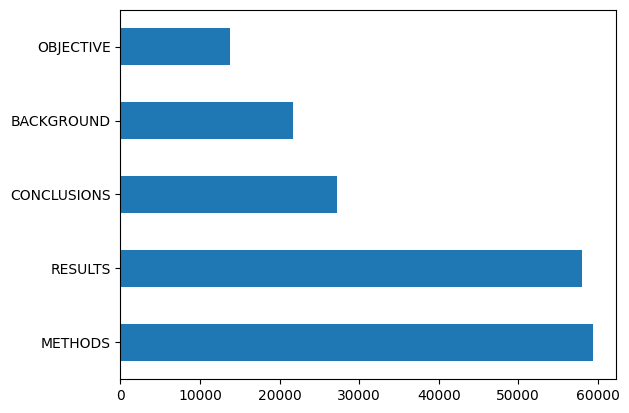

In [15]:
train_df["target"].value_counts().plot(kind="barh");

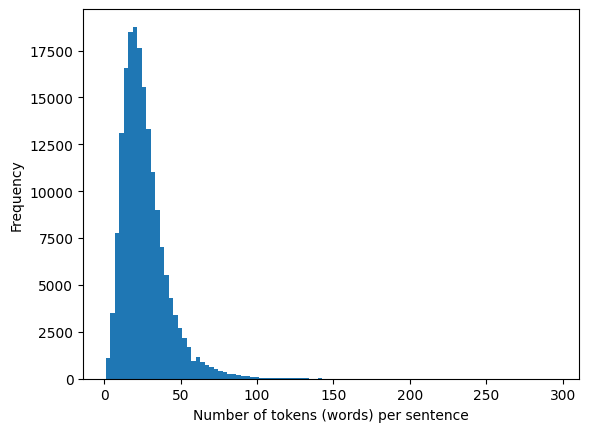

In [16]:
lengths_of_sentences = [len(sentence.split(" ")) for sentence in np.array(train_df["text"])]
pd.Series(lengths_of_sentences).plot(kind="hist", bins=100)
plt.xlabel("Number of tokens (words) per sentence");

In [17]:
# Check how some sentence looks like
train_df["text"][3].split(" ")

['Pain',
 'was',
 'assessed',
 'using',
 'the',
 'visual',
 'analog',
 'pain',
 'scale',
 '(',
 '@-@',
 'mm',
 ')',
 '.']

In [18]:
representative_output_sequence_length = int(np.percentile(lengths_of_sentences, 95))
print(representative_output_sequence_length)

55


## Extract text and labels from our dataset

In [19]:
train_sentences = np.array(train_df["text"])
valid_sentences = np.array(valid_df["text"])
test_sentences = np.array(test_df["text"])

train_labels = np.array(train_df["target"])
valid_labels = np.array(valid_df["target"])
test_labels = np.array(test_df["target"])

train_sentences[:2], valid_labels[:2], test_labels[:2]

(array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
        'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'],
       dtype=object),
 array(['BACKGROUND', 'BACKGROUND'], dtype=object),
 array(['BACKGROUND', 'RESULTS'], dtype=object))

In [20]:
NUM_CLASSES = len(np.unique(train_df["target"]))
NUM_CLASSES

5

## Preprocessing labels (one-hot-encoding and categorical encoding)

In [21]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
label_encoder = LabelEncoder()

# One hot encode labels
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
valid_labels_one_hot = one_hot_encoder.transform(valid_labels.reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1, 1))

# Encode labels to numbers
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_one_hot[:2], valid_labels_encoded[:2], test_labels_one_hot[:2]

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]]),
 array([0, 0]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]]))

# Start running series of experiments

## Model 0: baseline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("Tf-idf", TfidfVectorizer()),
    ("Naive-bayes", MultinomialNB())
])

model_0.fit(train_sentences,
            train_labels_encoded);

### Evaluate baseline model

In [ ]:
model_0_preds = model_0.predict(valid_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
model_0_results = calculate_results(valid_labels_encoded, model_0_preds)
model_0_results

{'accuracy_score': 0.7218323844829869,
 'precision_score': 0.7186466952323352,
 'recall_score': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Preprocess text using Vectorization and Embddings for deep models

In [22]:
VOCAB_SIZE = 68_000 # From original paper

token_vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                     output_sequence_length=representative_output_sequence_length)
token_embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                            output_dim=256, # 300 is an original number from the paper
                                            mask_zero=True, # For efficiency
                                            input_length=representative_output_sequence_length)
token_vectorizer.adapt(train_sentences)

## Create efficient pipelines using tf.data API

In [23]:
BATCH_SIZE = 32

def create_dataset(X, y, batch_size=BATCH_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices((X, y)).cache()
  return  dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [24]:
train_token_dataset = create_dataset(train_sentences, train_labels_one_hot)
valid_token_dataset = create_dataset(valid_sentences, valid_labels_one_hot)
test_token_dataset = create_dataset(test_sentences, test_labels_one_hot)
# Check if worked
train_token_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [ ]:
model_1_inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string)
x = token_vectorizer(model_1_inputs)
x = token_embedding(x)
x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(128, activation="swish",
                          kernel_initializer="he_normal")(x)
model_1_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_1 = tf.keras.Model(model_1_inputs, model_1_outputs)
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           17408000  
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           163968    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               1651

### Compile & train model_1

In [ ]:
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])
# Train a model
history_1 = model_1.fit(train_token_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_token_dataset)),
                        validation_data=(valid_token_dataset),
                        validation_steps=int(0.1 * len(valid_token_dataset)))

Epoch 1/5
562/562 [==============================] - 33s 56ms/step - loss: 0.7506 - accuracy: 0.7086 - val_loss: 0.5584 - val_accuracy: 0.7982
Epoch 2/5
562/562 [==============================] - 11s 20ms/step - loss: 0.5626 - accuracy: 0.7928 - val_loss: 0.5381 - val_accuracy: 0.8042
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5309 - accuracy: 0.8041 - val_loss: 0.5024 - val_accuracy: 0.8185
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5131 - accuracy: 0.8104 - val_loss: 0.5062 - val_accuracy: 0.8049
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5212 - accuracy: 0.8073 - val_loss: 0.4894 - val_accuracy: 0.8225


### Evaluate model_1

In [ ]:
model_1_preds_probs = model_1.predict(valid_sentences)
model_1_preds = np.argmax(model_1_preds_probs, axis=-1)
model_1_results = calculate_results(valid_labels_encoded, model_1_preds)
model_1_results

945/945 [==============================] - 4s 4ms/step


{'accuracy_score': 0.8142459949688865,
 'precision_score': 0.8262645843953871,
 'recall_score': 0.8142459949688865,
 'f1_score': 0.8131966066564843}

## Model 2: LSTM (long-short term memory)

In [ ]:
model_2_inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string)
x = token_vectorizer(model_2_inputs)
x = token_embedding(x)
x = tf.keras.layers.LSTM(units=64)(x)
model_2_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_2 = tf.keras.Model(model_2_inputs, model_2_outputs)
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           17408000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17,490,501
Trainable params: 17,490,501
Non-trainable params: 0
_______________________________________________

### Compile and train model_2

In [ ]:
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])
# Train a model
history_2 = model_2.fit(train_token_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_token_dataset)),
                        validation_data=(valid_token_dataset),
                        validation_steps=int(0.1 * len(valid_token_dataset)))

Epoch 1/5
562/562 [==============================] - 39s 62ms/step - loss: 0.6511 - accuracy: 0.7575 - val_loss: 0.6014 - val_accuracy: 0.7806
Epoch 2/5
562/562 [==============================] - 17s 30ms/step - loss: 0.5134 - accuracy: 0.8172 - val_loss: 0.6017 - val_accuracy: 0.7723
Epoch 3/5
562/562 [==============================] - 19s 34ms/step - loss: 0.4856 - accuracy: 0.8252 - val_loss: 0.5499 - val_accuracy: 0.7959
Epoch 4/5
562/562 [==============================] - 18s 33ms/step - loss: 0.4668 - accuracy: 0.8330 - val_loss: 0.5337 - val_accuracy: 0.8055
Epoch 5/5
562/562 [==============================] - 11s 20ms/step - loss: 0.4726 - accuracy: 0.8314 - val_loss: 0.5178 - val_accuracy: 0.8098


### Evaluate model_2

In [ ]:
model_2_preds_probs = model_2.predict(valid_sentences)
model_2_preds = np.argmax(model_2_preds_probs, axis=-1)
model_2_results = calculate_results(valid_labels_encoded, model_2_preds)
model_2_results

945/945 [==============================] - 6s 5ms/step


{'accuracy_score': 0.8067655236329935,
 'precision_score': 0.8100327539066503,
 'recall_score': 0.8067655236329935,
 'f1_score': 0.8053774902969707}

## Model_3: pretrained embeddings from TensorFlow Hub

In [ ]:
import tensorflow_hub as hub

**Note:** the Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

In [ ]:
USE_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
pretrained_embeddings_tf_hub_layer = hub.KerasLayer(USE_url, name="Universal_sentence_encoder_TF_HUB")

In [ ]:
model_3_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = pretrained_embeddings_tf_hub_layer(model_3_inputs)
x = tf.keras.layers.Dense(128, activation="swish",
                          kernel_initializer="he_normal")(x)
model_3_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_3 = tf.keras.Model(model_3_inputs, model_3_outputs)
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentence_encoder_  (None, 512)              256797824 
 TF_HUB (KerasLayer)                                             
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


### Compile and train model_3

In [ ]:
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])
# Train a model
history_3 = model_3.fit(train_token_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_token_dataset)),
                        validation_data=(valid_token_dataset),
                        validation_steps=int(0.1 * len(valid_token_dataset)))

Epoch 1/5
562/562 [==============================] - 12s 16ms/step - loss: 0.9404 - accuracy: 0.6422 - val_loss: 0.8088 - val_accuracy: 0.6885
Epoch 2/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7848 - accuracy: 0.6941 - val_loss: 0.7784 - val_accuracy: 0.6955
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7814 - accuracy: 0.7004 - val_loss: 0.7770 - val_accuracy: 0.7011
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7590 - accuracy: 0.7063 - val_loss: 0.7638 - val_accuracy: 0.7078
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7800 - accuracy: 0.6997 - val_loss: 0.7544 - val_accuracy: 0.7091


### Evaluate model_3

In [ ]:
model_3_preds_probs = model_3.predict(valid_sentences)
model_3_preds = np.argmax(model_3_preds_probs, axis=-1)
model_3_results = calculate_results(valid_labels_encoded, model_3_preds)
model_3_results

945/945 [==============================] - 10s 10ms/step


{'accuracy_score': 0.711306765523633,
 'precision_score': 0.7073758348330992,
 'recall_score': 0.711306765523633,
 'f1_score': 0.7056078390808834}

## Character embeddings

Previously we used token(word) embeddings to train our models. Now we are going to try character embeddings, so instead of splitting our sentences by entire words we are going to split them by letters.

Example text:*kursywa* "Hello friends. "

>* Token embeddings: ["Hello", "friends", "."].
* Characeter embeddings: ["H", "e", "l", "l", "o", "f", "r", "i", "e", "n", "d", "s", "."]

In [ ]:
def split_sentence_into_characters(sentence):
  return " ".join(list(sentence))

# Check of our function is working
some_sentence = train_sentences[1]
split_sentence_into_characters(some_sentence)

'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [ ]:
char_train_sentences = [split_sentence_into_characters(sentence) for sentence in train_sentences]
char_valid_sentences = [split_sentence_into_characters(sentence) for sentence in valid_sentences]
char_test_sentences = [split_sentence_into_characters(sentence) for sentence in test_sentences]
# Check if it worked
char_test_sentences[:2]

['T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )   .',
 'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )   .']

### Create efficient data pipelines for character embeddings

In [ ]:
char_train_dataset = create_dataset(char_train_sentences, train_labels_one_hot)
char_valid_dataset = create_dataset(char_valid_sentences, valid_labels_one_hot)
char_test_dataset = create_dataset(char_test_sentences, test_labels_one_hot)
# Check if our dataset are correct
char_train_dataset, char_test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Creating character vectorizer and embedding layers

In [ ]:
# Use string python module to get all keyboard letters
import string

alphabet = string.ascii_lowercase + string.punctuation + string.digits
CHAR_VOCAB_SIZE = len(alphabet) + 2 # We add one for spaces and one for OOV
print(f"Alphabet: {alphabet}\nLength of an alphabeth: {CHAR_VOCAB_SIZE}")

Alphabet: abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789
Length of an alphabeth: 70


In [ ]:
char_sequences_lengths = [len(sentence.split()) for sentence in char_train_sentences]
char_sequences_means = np.mean(char_sequences_lengths)
char_sequences_means

124.02798822483892

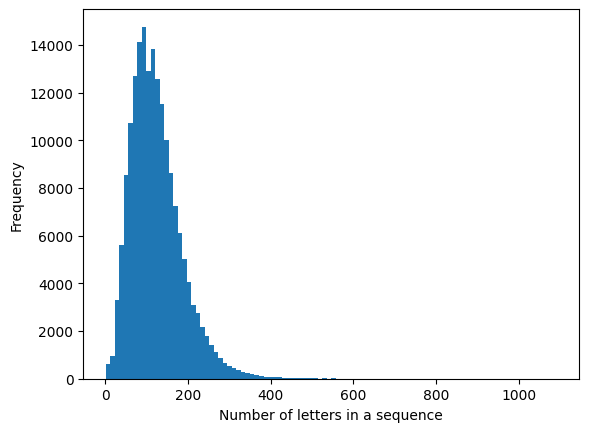

In [ ]:
# Visualize above lengths
pd.Series(char_sequences_lengths).plot(kind="hist", bins=100)
plt.xlabel("Number of letters in a sequence");

In [ ]:
representative_number_of_chars = int(np.percentile(char_sequences_lengths, 98))
representative_number_of_chars

285

In [ ]:
char_text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=CHAR_VOCAB_SIZE,
                                                      output_sequence_length=representative_number_of_chars)
char_embedding = tf.keras.layers.Embedding(input_dim=CHAR_VOCAB_SIZE,
                                           output_dim=25,
                                           mask_zero=True,
                                           input_length=representative_number_of_chars)
# Call vectorizer adapt method
char_text_vectorizer.adapt(char_train_sentences)

## Model 4: character embeddings with bidirectional layer

In [ ]:
model_4_inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string)
x = char_text_vectorizer(model_4_inputs)
x = char_embedding(x)
x = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=256))(x)
x = tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal")(x)
model_4_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_4 = tf.keras.Model(model_4_inputs, model_4_outputs)
model_4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 285)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 285, 25)           1750      
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              577536    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 5)                 645 

### Compile and train model_4

In [ ]:
model_4.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])
# Train a model
history_4 = model_4.fit(char_train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(char_train_dataset)),
                        validation_data=(char_valid_dataset),
                        validation_steps=int(0.1 * len(char_valid_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 51ms/step - loss: 1.3661 - accuracy: 0.4207 - val_loss: 1.2762 - val_accuracy: 0.4781
Epoch 2/5
562/562 [==============================] - 26s 45ms/step - loss: 1.2113 - accuracy: 0.4931 - val_loss: 1.1706 - val_accuracy: 0.5206
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 1.1698 - accuracy: 0.5209 - val_loss: 1.1771 - val_accuracy: 0.5120
Epoch 4/5
562/562 [==============================] - 26s 47ms/step - loss: 1.0907 - accuracy: 0.5474 - val_loss: 1.0555 - val_accuracy: 0.5648
Epoch 5/5
562/562 [==============================] - 24s 43ms/step - loss: 1.0782 - accuracy: 0.5560 - val_loss: 1.0303 - val_accuracy: 0.5718


### Evaluate model_4

In [ ]:
model_4_preds_probs = model_4.predict(char_valid_sentences)
model_4_preds = np.argmax(model_4_preds_probs, axis=-1)
model_4_results = calculate_results(valid_labels_encoded, model_4_preds)
model_4_results

945/945 [==============================] - 15s 14ms/step


{'accuracy_score': 0.5811598040513704,
 'precision_score': 0.5955406424394569,
 'recall_score': 0.5811598040513704,
 'f1_score': 0.5744679259244583}

## Model 5: replicating original model from the paper

In [ ]:
# Clear keras backend and make our code reproducible
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Create char model
char_inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string, name="char_input")
char_vectorizer = char_text_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectorizer)
char_bi_lstm = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=64))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Create token model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedded = pretrained_embeddings_tf_hub_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(256, activation="relu",
                                      kernel_initializer="he_normal")(token_embedded)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Concatenate 2 above models
hybrid_embeddings = tf.keras.layers.Concatenate()([char_model.output, token_model.output])

# Add another droput and dense layers on top
dropout_1 = tf.keras.layers.Dropout(0.5)(hybrid_embeddings)
hybrid_dense_1 = tf.keras.layers.Dense(256, activation="relu",
                                      kernel_initializer="he_normal")(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.5)(hybrid_dense_1)
hybrid_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="final_output")(dropout_2)

# Construct final model
model_5 = tf.keras.Model(inputs=[char_inputs, token_inputs], outputs=hybrid_outputs)
model_5.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 285)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 285, 25)      1750        ['text_vectorization_1[1][0

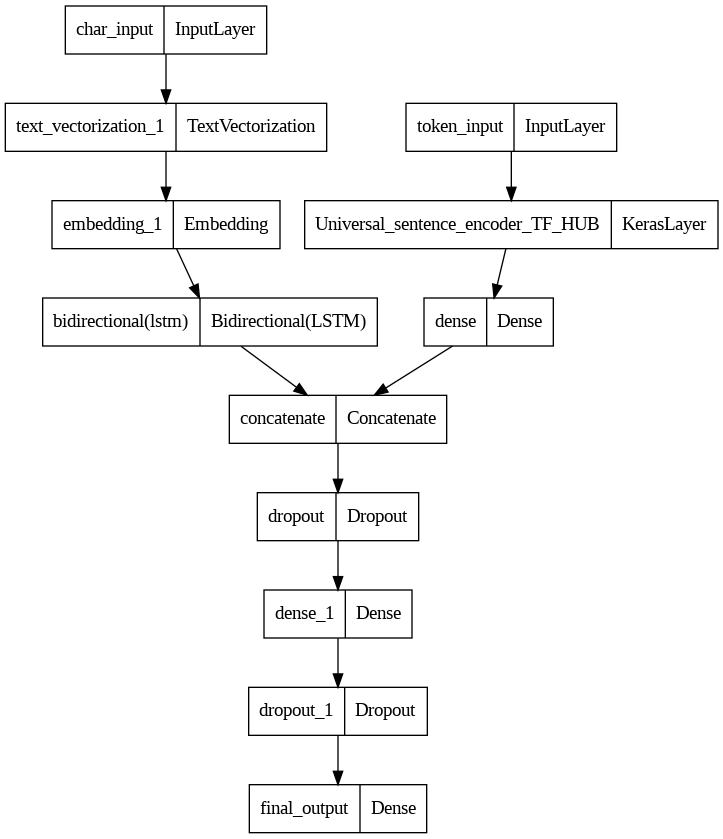

In [ ]:
tf.keras.utils.plot_model(model_5)

### Create efficient data pipelines for our model_5

In [ ]:
# Combine characters and tokens datasets into one dataset
token_char_train_dataset_  = tf.data.Dataset.from_tensor_slices((char_train_sentences, train_sentences))
token_char_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
token_char_train_dataset = tf.data.Dataset.zip((token_char_train_dataset_, token_char_train_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Do exact same as above but now with validation dataset
token_char_valid_dataset_  = tf.data.Dataset.from_tensor_slices((char_valid_sentences, valid_sentences))
token_char_valid_labels = tf.data.Dataset.from_tensor_slices(valid_labels_one_hot)
token_char_valid_dataset = tf.data.Dataset.zip((token_char_valid_dataset_, token_char_valid_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check if our datasets are prefetched
token_char_train_dataset, token_char_valid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Compile and train model_5

In [ ]:
model_5.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])
# Train a model
history_5 = model_5.fit(token_char_train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(token_char_train_dataset)),
                        validation_data=(token_char_valid_dataset),
                        validation_steps=int(0.1 * len(token_char_valid_dataset)))

Epoch 1/5
562/562 [==============================] - 46s 59ms/step - loss: 0.9200 - accuracy: 0.6368 - val_loss: 0.7549 - val_accuracy: 0.7131
Epoch 2/5
562/562 [==============================] - 31s 55ms/step - loss: 0.7614 - accuracy: 0.7090 - val_loss: 0.6988 - val_accuracy: 0.7394
Epoch 3/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7363 - accuracy: 0.7155 - val_loss: 0.6708 - val_accuracy: 0.7467
Epoch 4/5
562/562 [==============================] - 33s 59ms/step - loss: 0.7084 - accuracy: 0.7332 - val_loss: 0.6434 - val_accuracy: 0.7600
Epoch 5/5
562/562 [==============================] - 29s 52ms/step - loss: 0.7126 - accuracy: 0.7295 - val_loss: 0.6326 - val_accuracy: 0.7600


In [ ]:
model_5_preds_probs = model_5.predict(token_char_valid_dataset)
model_5_preds = np.argmax(model_5_preds_probs, axis=-1)
model_5_results = calculate_results(valid_labels_encoded, model_5_preds)
model_5_results

945/945 [==============================] - 30s 32ms/step


{'accuracy_score': 0.7552297100489872,
 'precision_score': 0.7511414728374031,
 'recall_score': 0.7552297100489872,
 'f1_score': 0.7498917266813884}

In [ ]:
pd.Series(model_0_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_0_results")
pd.Series(model_1_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_1_results")
pd.Series(model_2_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_2_results")
pd.Series(model_3_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_3_results")
pd.Series(model_4_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_4_results")
pd.Series(model_5_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_5_results")

## Prepare line_number and total_lines features for model_6

In [ ]:
# Extract line_number and total_lines from train_df
train_line_number = np.array(train_df["line_number"])
train_total_lines = np.array(train_df["total_lines"])
train_line_number[:15], train_total_lines[:15]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2]),
 array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10]))

In [ ]:
# Same as above but now for validation dataset
valid_line_number = np.array(valid_df["line_number"])
valid_total_lines = np.array(valid_df["total_lines"])
valid_line_number[:15], valid_total_lines[:15]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4]),
 array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10]))

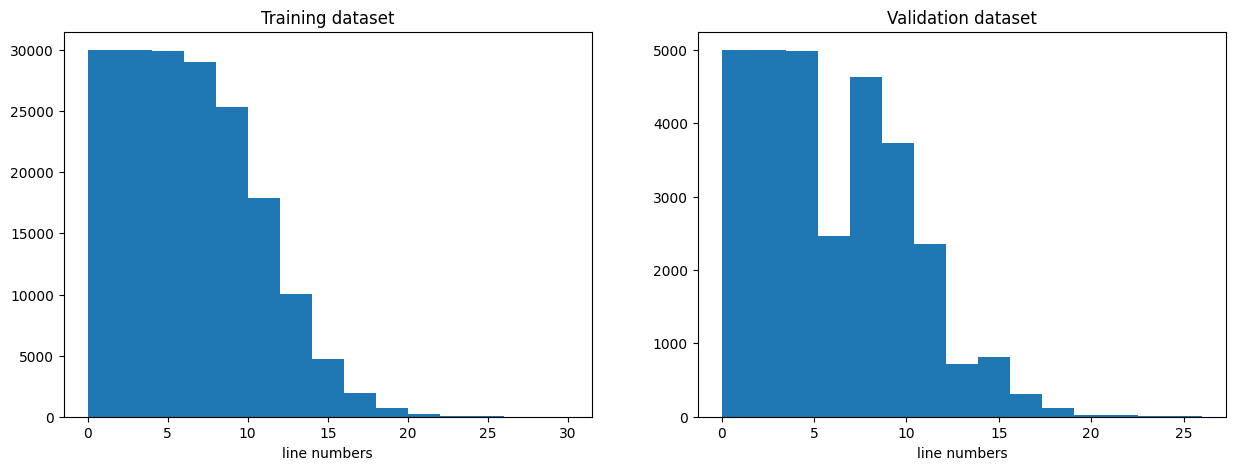

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
plt.hist(pd.Series(train_line_number), bins=15)
plt.xlabel("line numbers")
plt.title("Training dataset")
fig.add_subplot(1, 2, 2)
plt.hist(pd.Series(valid_line_number), bins=15)
plt.xlabel("line numbers")
plt.title("Validation dataset");

In [ ]:
representative_line_number_number = int(np.percentile(train_line_number, 98))
representative_line_number_number

15

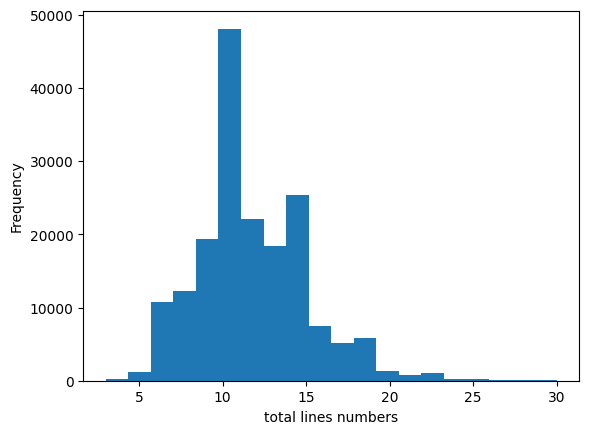

In [ ]:
pd.Series(train_total_lines).plot(kind="hist", bins=20)
plt.xlabel("total lines numbers");

In [ ]:
representative_total_line_number = int(np.percentile(train_total_lines, 98))
representative_total_line_number

20

### Create one-hot-representation of line_number and total_lines features

In [ ]:
train_line_number_one_hot = tf.one_hot(train_line_number, depth=representative_line_number_number)
train_total_lines_one_hot = tf.one_hot(train_total_lines, depth=representative_total_line_number)
# Check if featurs are properly one-hot encoded
train_line_number_one_hot, train_total_lines_one_hot

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [ ]:
# Now for the validation dataset
valid_line_number_one_hot = tf.one_hot(valid_line_number, depth=15)
valid_total_lines_one_hot = tf.one_hot(valid_total_lines, depth=20)
# Check if featurs are properly one-hot encoded
valid_line_number_one_hot, valid_total_lines_one_hot

(<tf.Tensor: shape=(30212, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30212, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

## Model 6: in this model we are going to use 2 additional features: total_lines, line_number

In [ ]:
# Clear keras backend and make our code reproducible
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Create char model
char_inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string, name="char_input")
char_vectorizer = char_text_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectorizer)
char_bi_lstm = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=64))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Create token model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedded = pretrained_embeddings_tf_hub_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(256, activation="relu",
                                      kernel_initializer="he_normal")(token_embedded)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Create line_number model (we can treat one-hot represenatation as and embedding arleady)
line_number_inputs = tf.keras.layers.Input(shape=[15,], dtype=tf.float32, name="line_number_input")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu",
                                          kernel_initializer="he_normal")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# Create total_lines model
total_lines_inputs = tf.keras.layers.Input(shape=[20,], dtype=tf.float32, name="total_line_number_input")
total_lines_outputs = tf.keras.layers.Dense(32, activation="relu",
                                          kernel_initializer="he_normal")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# Concatenate token and char models
char_token_embeddings = tf.keras.layers.Concatenate()([char_model.output, token_model.output])
char_token_dense = tf.keras.layers.Dense(256, activation="relu",
                                          kernel_initializer="he_normal")(char_token_embeddings)
dropout_1 = tf.keras.layers.Dropout(0.5)(char_token_dense)

# Concatenate all 3 models (token_char, line_number, total_lines)
hybrid_embeddings = tf.keras.layers.Concatenate()([dropout_1, line_number_model.output, total_lines_model.output])

# Add some dropout and dense layers on top
hybrid_dense_1 = tf.keras.layers.Dense(256, activation="relu",
                                       kernel_initializer="he_normal")(hybrid_embeddings)
dropout_2 = tf.keras.layers.Dropout(0.5)(hybrid_dense_1)
final_outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="final_softmax_output")(hybrid_dense_1)

# Construct final model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[char_inputs, token_inputs, line_number_inputs, total_lines_inputs],
                         outputs=[final_outputs],
                         name="tribrid_embedding_model_5")
# Check the summary
model_6.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 285)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 285, 25)      1750        ['text_ve

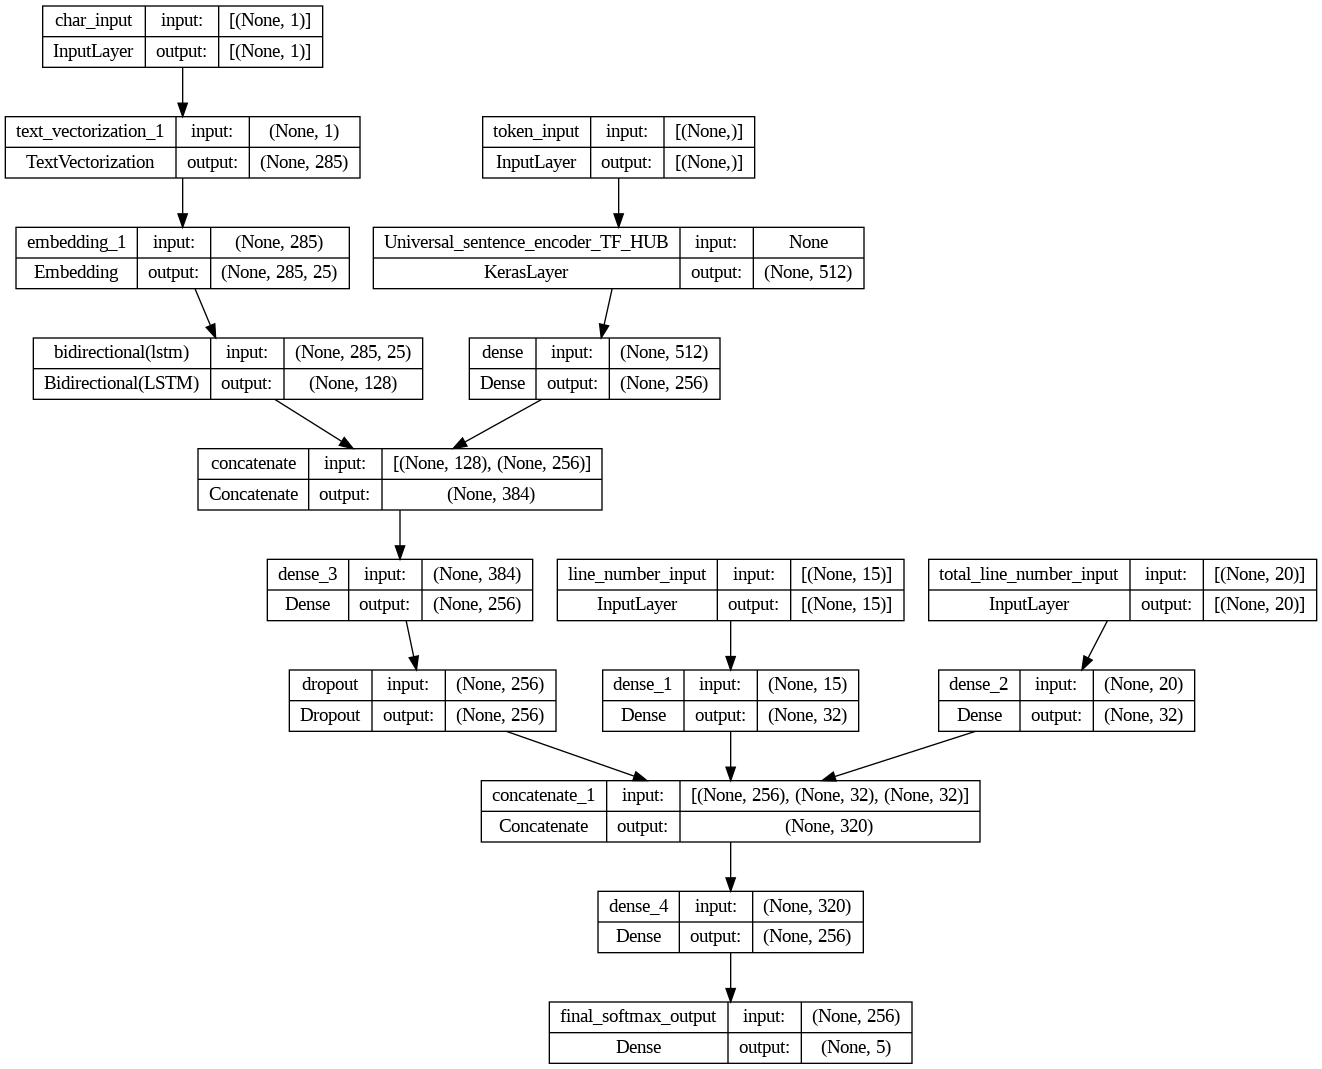

In [ ]:
# Check the architecture of model_6
tf.keras.utils.plot_model(model_6, show_shapes=True)

### Create efficient data pipelines for model_6

In [ ]:
train_token_char_line_number_total_dataset_ = tf.data.Dataset.from_tensor_slices((char_train_sentences,
                                                                                  train_sentences,
                                                                                  train_line_number_one_hot,
                                                                                  train_total_lines_one_hot)).cache()
# Dataset for labels
train_token_char_line_number_total_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# Combined sentences, line_numbers, total_lines and one-hot encoded labels
train_token_char_line_number_total_dataset = tf.data.Dataset.zip((train_token_char_line_number_total_dataset_,
                                                                  train_token_char_line_number_total_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Check if our dataset is correctly prefetched
train_token_char_line_number_total_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Do the same as in above cell, but now for validation dataset
valid_token_char_line_number_total_dataset_ = tf.data.Dataset.from_tensor_slices((char_valid_sentences,
                                                                                  valid_sentences,
                                                                                  valid_line_number_one_hot,
                                                                                  valid_total_lines_one_hot)).cache()
# Dataset for labels
valid_token_char_line_number_total_labels = tf.data.Dataset.from_tensor_slices(valid_labels_one_hot)
# Combined sentences, line_numbers, total_lines and one-hot encoded labels
valid_token_char_line_number_total_dataset = tf.data.Dataset.zip((valid_token_char_line_number_total_dataset_,
                                                                  valid_token_char_line_number_total_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Check if our dataset is correctly prefetched
valid_token_char_line_number_total_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# # Do the same as in above cell, but now for the test dataset
# test_token_char_line_number_total_dataset_ = tf.data.Dataset.from_tensor_slices((char_test_sentences,
#                                                                                  test_sentences,
#                                                                                  test_line_number_one_hot,
#                                                                                  test_total_lines_one_hot)).cache()
# # Dataset for labels
# test_token_char_line_number_total_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
# # Combined sentences, line_numbers, total_lines and one-hot encoded labels
# test_token_char_line_number_total_dataset = tf.data.Dataset.zip((test_token_char_line_number_total_dataset_,
#                                                                  test_token_char_line_number_total_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# # Check if our dataset is correctly prefetched
# test_token_char_line_number_total_dataset

### Compile and fit model_6

**What is label smoothing?**

For example if our model gets too confident on a single class  (it's prediction probability is really high), it may get stuck on that class and not consider other classes.

Really confident: `[0., 0., 0., 1., 0.]`

What label smoothing does is it assigns some of the value from the highest prediction probability to other classes , in turn, hopefully improving generalization: `[0.01, 0.01, 0.01, 0.96, 0.01]`.

In [ ]:
# Compile our model :)
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # It helps to prevent overfitting
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"])

In [ ]:
# Train a model
history_6 = model_6.fit(train_token_char_line_number_total_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_token_char_line_number_total_dataset)),
                        validation_data=(valid_token_char_line_number_total_dataset),
                        validation_steps=int(0.1 * len(valid_token_char_line_number_total_dataset)),
                        callbacks=[create_early_stopping_callback(patience=7),
                                   create_tensorboard_callback("model_6_10_percent_data", "drive/MyDrive/projects/SkimLit/tensorboard")])

Saving tensorboard callback to: drive/MyDrive/projects/SkimLit/tensorboard/model_6_10_percent_data/run_2023_08_12_11_29_16
Epoch 1/5
562/562 [==============================] - 92s 59ms/step - loss: 1.0314 - accuracy: 0.7647 - val_loss: 0.9354 - val_accuracy: 0.8285
Epoch 2/5
562/562 [==============================] - 45s 80ms/step - loss: 0.9211 - accuracy: 0.8360 - val_loss: 0.9007 - val_accuracy: 0.8477
Epoch 3/5
562/562 [==============================] - 34s 60ms/step - loss: 0.9006 - accuracy: 0.8446 - val_loss: 0.8846 - val_accuracy: 0.8597
Epoch 4/5
562/562 [==============================] - 32s 57ms/step - loss: 0.8916 - accuracy: 0.8539 - val_loss: 0.8829 - val_accuracy: 0.8561
Epoch 5/5
562/562 [==============================] - 33s 60ms/step - loss: 0.8864 - accuracy: 0.8554 - val_loss: 0.8739 - val_accuracy: 0.8594


### Evaluating model_6

In [ ]:
model_6_preds_probs = model_6.predict(valid_token_char_line_number_total_dataset)
model_6_preds = np.argmax(model_6_preds_probs, axis=-1)
model_6_preds[:10]

945/945 [==============================] - 24s 22ms/step


array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [ ]:
model_6_results = calculate_results(valid_labels_encoded, model_6_preds)
model_6_results

{'accuracy_score': 0.8623725671918443,
 'precision_score': 0.8669735122265203,
 'recall_score': 0.8623725671918443,
 'f1_score': 0.8590754611913429}

In [ ]:
pd.Series(model_6_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_6_10_percent_data")

## Saving our best model (trained on 10% of the data)

In [ ]:
save_model(model_6, "model_6_10_percent")
loaded_model = load_model("model_6_10_percent")

In [ ]:
# Check if predictions are the same
compare_predictions(model_6, loaded_model, valid_token_char_line_number_total_dataset.take(100))

## Training our model on 100% of the data

In [ ]:
# Train a model
history_6_100_percent_data = model_6.fit(train_token_char_line_number_total_dataset,
                                         epochs=50,
                                         validation_data=(valid_token_char_line_number_total_dataset),
                                         callbacks=[create_early_stopping_callback(patience=7),
                                                    create_tensorboard_callback("model_6_100_percent_data", "drive/MyDrive/projects/SkimLit/tensorboard"),
                                                    create_modelcheckpoint_callback("model_6_100_percent_data", "drive/MyDrive/projects/SkimLit/model_checkpoint")])

Saving tensorboard callback to: drive/MyDrive/projects/SkimLit/tensorboard/model_6_100_percent_data/run_2023_08_12_11_39_19
Saving model checkpoints to: drive/MyDrive/projects/SkimLit/model_checkpoint/model_6_100_percent_data
Epoch 1/50
5627/5627 [==============================] - 352s 62ms/step - loss: 0.8678 - accuracy: 0.8663 - val_loss: 0.8547 - val_accuracy: 0.8721
Epoch 2/50
5627/5627 [==============================] - 332s 59ms/step - loss: 0.8490 - accuracy: 0.8783 - val_loss: 0.8499 - val_accuracy: 0.8750
Epoch 3/50
5627/5627 [==============================] - 339s 60ms/step - loss: 0.8355 - accuracy: 0.8877 - val_loss: 0.8441 - val_accuracy: 0.8795
Epoch 4/50
5627/5627 [==============================] - 323s 57ms/step - loss: 0.8248 - accuracy: 0.8949 - val_loss: 0.8480 - val_accuracy: 0.8757
Epoch 5/50
5627/5627 [==============================] - 310s 55ms/step - loss: 0.8160 - accuracy: 0.9022 - val_loss: 0.8537 - val_accuracy: 0.8745
Epoch 6/50
5627/5627 [=================

In [ ]:
model_6_100_percent_preds_probs = model_6.predict(valid_token_char_line_number_total_dataset)
model_6_100_percent_preds = np.argmax(model_6_100_percent_preds_probs, axis=-1)
model_6_100_percent_preds[:10]

945/945 [==============================] - 21s 22ms/step


array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [ ]:
model_6_100_percent_results = calculate_results(valid_labels_encoded, model_6_100_percent_preds)
model_6_100_percent_results

{'accuracy_score': 0.8728650867205084,
 'precision_score': 0.875382701224152,
 'recall_score': 0.8728650867205084,
 'f1_score': 0.870100976725829}

In [ ]:
pd.Series(model_6_100_percent_results).to_csv("drive/MyDrive/projects/SkimLit/csv_files" + "model_6_100_percent")

# Visualize our experiments

## Comparing all model experiments

In [ ]:
all_model_results = pd.DataFrame({"model_1_Conv1D": model_1_results,
                                  "model_2_LSTM": model_2_results,
                                  "model_3_TF_HUB_embeddings": model_3_results,
                                  "model_4_bidirectional": model_4_results,
                                  "model_5_char_token_embeddings": model_5_results,
                                  "model_6_char_token_position_embeddings": model_6_results,
                                  "model_7_char_token_posiition_100_data": model_6_100_percent_results})
all_model_results = all_model_results.T
all_model_results

,accuracy_score,precision_score,recall_score,f1_score
model_1_Conv1D,0.814246,0.826265,0.814246,0.813197
model_2_LSTM,0.806766,0.810033,0.806766,0.805377
model_3_TF_HUB_embeddings,0.711307,0.707376,0.711307,0.705608
model_4_bidirectional,0.581160,0.595541,0.581160,0.574468
model_5_char_token_embeddings,0.755230,0.751141,0.755230,0.749892
model_6_char_token_position_embeddings,0.862373,0.866974,0.862373,0.859075
model_7_char_token_posiition_100_data,0.872865,0.875383,0.872865,0.870101


In [ ]:
all_model_results.to_csv("/content/drive/MyDrive/projects/SkimLit/csv_files/all_model_results")

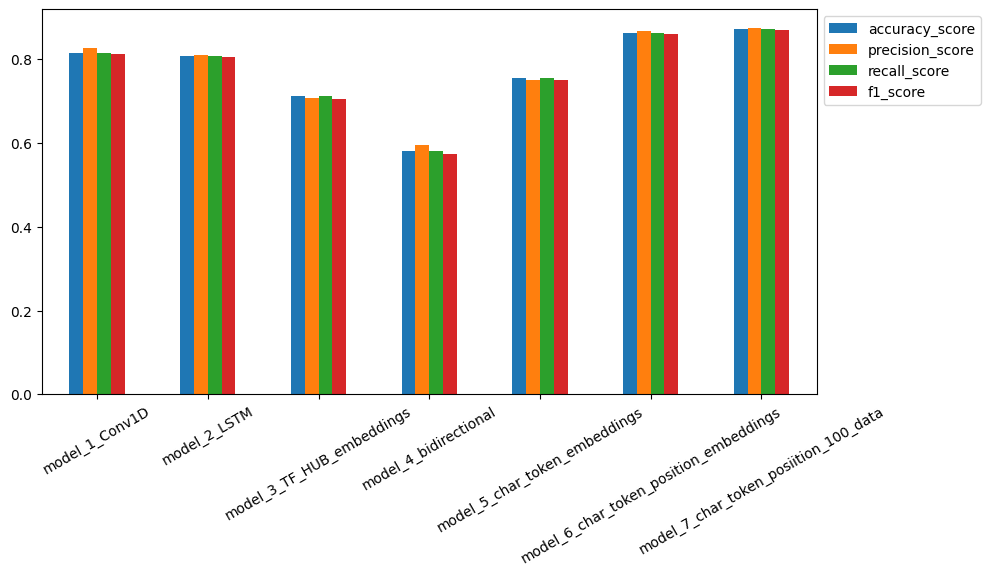

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 5), rot=30).legend(bbox_to_anchor=(1.0, 1.0));

## Build plot for F1 score

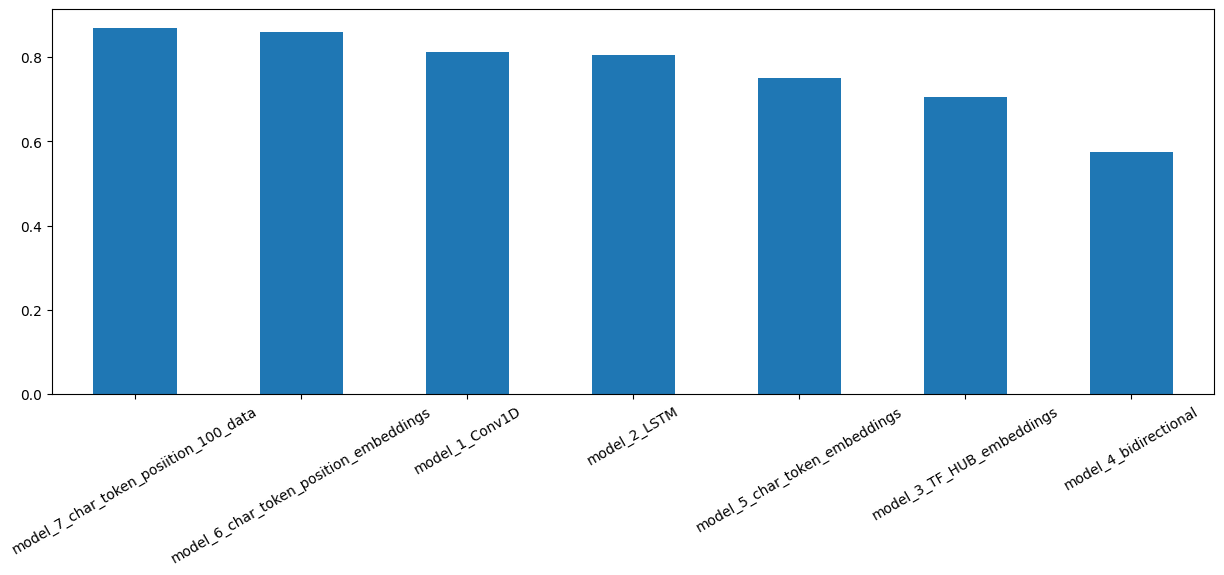

In [ ]:
all_model_results.sort_values(by="f1_score", ascending=False).loc[:, "f1_score"].plot(kind="bar", rot=30, figsize=(15, 5));

## Build confusion matrix based on model_6 predictions

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_labels_encoded, model_6_100_percent_preds)
pd.DataFrame(cm)

,0,1,2,3,4
0,2996,29,172,239,13
1,50,4083,28,1,420
2,103,39,9158,29,635
3,1074,0,117,1182,3
4,15,296,578,0,8952


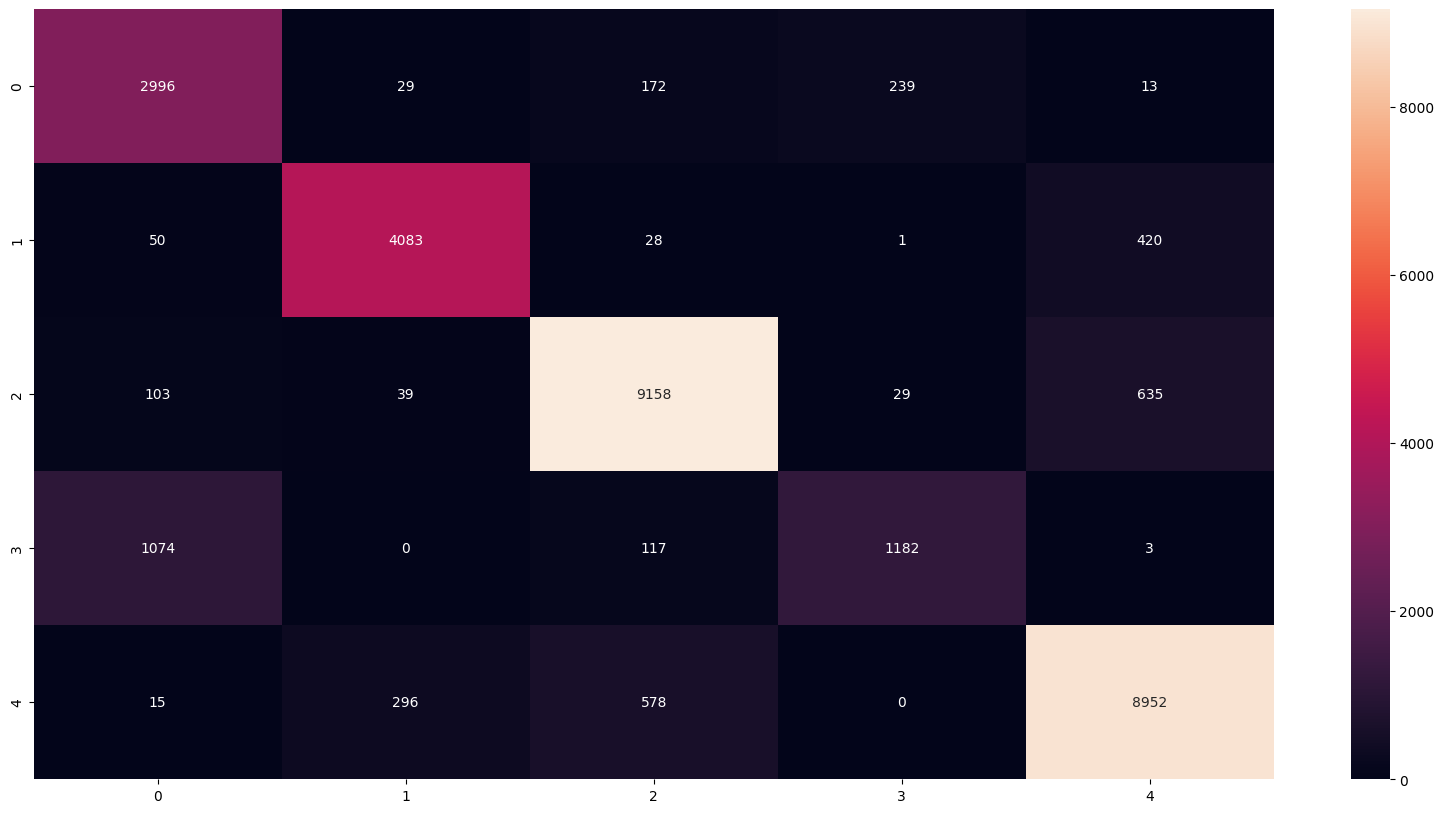

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
sns.heatmap(cm,
            annot=True,
            fmt='.0f');

# Use our model on our custom abstract

In [231]:
def get_one_single_line_in_file(filename, filename_2="drive/MyDrive/projects/SkimLit/preprocessed_test.txt"):
  lines = []
  with open(filename, "r") as f:
    for line in f:
      lines.append(line.strip())
  line_string = " ".join(lines)
  with open(filename_2, "w") as f:
    for sentence in line_string:
      f.write(sentence)

In [232]:
get_one_single_line_in_file("drive/MyDrive/projects/SkimLit/test.txt")

In [233]:
def split_sentence_into_characters(sentence):
    return " ".join(list(sentence))


def preprocess_data_from_some_article(filename,
                                      representative_line_number_number=15,
                                      representative_total_line_number=20):
    with open(filename, "r") as f:
        file = f.readlines()

    all_sentences = ""
    for line in file:
        all_sentences += str(line)
    # Split data into array, each element is going to be some sentence
    all_sentences = all_sentences.split(". ")
    all_sentences = list(filter(lambda sentence: len(sentence) > 1, all_sentences))
    # Now create line_number and total_lines features (feature engineering)
    total_lines = [len(all_sentences) - 1 for _ in range(len(all_sentences))]
    print(f"Total number of words: {total_lines}")
    line_number = [i for i in range(len(all_sentences))]
    print(f"Line numbers indexes: {line_number}")

    # Create token sentences (one of four types of inputs done)
    token_sentences = all_sentences

    # Now create char sentences
    char_sentences = [split_sentence_into_characters(sentence) for sentence in all_sentences]

    # Return token sentences, char sentences, line_number one-hot-encoded, total_lines one-hot-encoded
    return (token_sentences,
            char_sentences,
            tf.one_hot(line_number, depth=representative_line_number_number),
            tf.one_hot(total_lines, depth=representative_total_line_number))

In [234]:
own_token_sentences, own_char_sentences, own_line_number, own_total_lines = preprocess_data_from_some_article("drive/MyDrive/projects/SkimLit/preprocessed_test.txt")

Total number of words: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Line numbers indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [235]:
own_random_labels = []
for _ in range(len(own_token_sentences)):
  own_random_labels.append([1., 0, 0, 0, 0])

own_random_labels[:5]

[[1.0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0]]

In [208]:
# Arleady so I commented below lines

# final_model = load_model("model_6_10_percent_data", "/content/drive/MyDrive/projects/SkimLit/model_checkpoint")
# final_model

## Create data pipelines for our own custom data

In [209]:
own_token_char_line_number_total_dataset_ = tf.data.Dataset.from_tensor_slices((own_token_sentences,
                                                                                own_char_sentences,
                                                                                own_line_number,
                                                                                own_total_lines)).prefetch(tf.data.AUTOTUNE)
# Dataset for labels
own_token_char_line_number_total_labels = tf.data.Dataset.from_tensor_slices(own_random_labels)


# Combined sentences, line_numbers, total_lines and one-hot encoded labels
own_token_char_line_number_total_dataset = tf.data.Dataset.zip((own_token_char_line_number_total_dataset_,
                                                                  own_token_char_line_number_total_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Check if our dataset is correctly prefetched
own_token_char_line_number_total_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [210]:
final_model_preds_probs = final_model.predict(own_token_char_line_number_total_dataset)
final_model_preds_probs[:5]

1/1 [==============================] - 0s 122ms/step


array([[0.3875134 , 0.03255567, 0.11660347, 0.3717548 , 0.09157258],
       [0.27150676, 0.02299358, 0.3978807 , 0.23923841, 0.06838074],
       [0.11291058, 0.03057126, 0.64741683, 0.09864698, 0.1104544 ],
       [0.14542899, 0.03729133, 0.5985169 , 0.08848654, 0.13027628],
       [0.09364188, 0.05528347, 0.4681506 , 0.06516858, 0.3177554 ]],
      dtype=float32)

In [211]:
final_model_preds = np.argmax(final_model_preds_probs, axis=-1)
# Save it as a csv file
pd.Series(final_model_preds).to_csv("drive/MyDrive/projects/SkimLit/own_custom_preds")
final_model_preds

array([0, 2, 2, 2, 2, 4, 4, 4, 4, 4])

In [212]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Formatting model predictions

In [213]:
def output_lines_from_own_file(filename):
  with open(filename, "r") as f:
      file = f.readlines()

  all_sentences = ""
  for line in file:
      all_sentences += str(line)
  # Split data into array, each element is going to be some sentence
  all_sentences = all_sentences.split(". ")
  all_sentences = list(filter(lambda sentence: len(sentence) > 1, all_sentences))
  return all_sentences

In [214]:
own_file_lines = output_lines_from_own_file("drive/MyDrive/projects/SkimLit/preprocessed_test.txt")

In [215]:
def create_and_write_model_results_to_file(predictions, lines, filename="drive/MyDrive/projects/SkimLit/results.txt"):
  target_line_dictionary = {}

  how_many_repeats = 0
  previous = "-"
  with open(filename, "w") as f:
    for idx, line in enumerate(lines):

      target_prediction = CLASS_NAMES[predictions[idx]]
      if target_prediction == previous and how_many_repeats < 6:
        f.write(f"\t\t{line}.\n")
        previous = target_prediction
        how_many_repeats += 1

      else:
        how_many_repeats = 0
        if idx == 0:
          f.write(f"{str(target_prediction).title()}\n")
        else:
          f.write(f"\n\n{str(target_prediction).title()}\n")
        f.write(f"\t\t{line}.")
        previous = target_prediction

In [216]:
create_and_write_model_results_to_file(final_model_preds, own_file_lines)

# Combine Everything in one cell

In [236]:
# This function reads any file and writes every sentence to another file, but now everything will be in one line
def get_one_single_line_in_file(filename, filename_2="drive/MyDrive/projects/SkimLit/preprocessed_test.txt"):
  """
  File that contains original text (path on my own google drive): "drive/MyDrive/projects/SkimLit/test.txt".
  File that will contain everything in one line (path on my own google drive): "drive/MyDrive/projects/SkimLit/preprocessed_test.txt".
  """
  lines = []
  with open(filename, "r") as f:
    for line in f:
      lines.append(line.strip())
  line_string = " ".join(lines)
  with open(filename_2, "w") as f:
    for sentence in line_string:
      f.write(sentence)

# This function split sentence into single characters (will be useful when creating char embeddings)
def split_sentence_into_characters(sentence):
    return " ".join(list(sentence))

# This file reads preprocessed file (file was preprocessed by first function in this cell) and returns all types of inputs that we need for our model
def preprocess_data_from_some_article(filename,
                                      representative_line_number_number=15,
                                      representative_total_line_number=20):
    with open(filename, "r") as f:
        file = f.readlines()

    all_sentences = ""
    for line in file:
        all_sentences += str(line)
    # Split data into array, each element is going to be some sentence
    all_sentences = all_sentences.split(". ")
    all_sentences = list(filter(lambda sentence: len(sentence) > 1, all_sentences))
    # Now create line_number and total_lines features (feature engineering)
    total_lines = [len(all_sentences) - 1 for _ in range(len(all_sentences))]
    print(f"Total number of words: {total_lines}")
    line_number = [i for i in range(len(all_sentences))]
    print(f"Line numbers indexes: {line_number}")

    # Create token sentences (one of four types of inputs done)
    token_sentences = all_sentences

    # Now create char sentences
    char_sentences = [split_sentence_into_characters(sentence) for sentence in all_sentences]

    # Return token sentences, char sentences, line_number one-hot-encoded, total_lines one-hot-encoded
    return (token_sentences,
            char_sentences,
            tf.one_hot(line_number, depth=representative_line_number_number),
            tf.one_hot(total_lines, depth=representative_total_line_number))

# This function creates some random labels (necessary for our datasets)
def create_own_labels(own_token_sentences):
  own_random_labels = []
  for _ in range(len(own_token_sentences)):
    own_random_labels.append([1., 0, 0, 0, 0])
  return own_random_labels


# This function creates efficient pipelines for our datasets
def create_own_datasets(own_token_sentences, own_char_sentences, own_line_number, own_total_lines, own_random_labels):
  own_token_char_line_number_total_dataset_ = tf.data.Dataset.from_tensor_slices((own_token_sentences,
                                                                                  own_char_sentences,
                                                                                  own_line_number,
                                                                                  own_total_lines)).cache()
  # Dataset for labels
  own_token_char_line_number_total_labels = tf.data.Dataset.from_tensor_slices(own_random_labels)


  # Combined sentences, line_numbers, total_lines and one-hot encoded labels
  own_token_char_line_number_total_dataset = tf.data.Dataset.zip((own_token_char_line_number_total_dataset_,
                                                                    own_token_char_line_number_total_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  # Check if our dataset is correctly prefetched
  return own_token_char_line_number_total_dataset


# This function returns encoded predictions that our model has made
def get_model_preds(final_model, own_dataset):
  final_model_preds_probs = final_model.predict(own_dataset)
  final_model_preds = np.argmax(final_model_preds_probs, axis=-1)
  # Save above predictions as a csv file
  pd.Series(final_model_preds).to_csv("drive/MyDrive/projects/SkimLit/own_custom_preds")
  return final_model_preds

# This function gives all lines form original abstract
def output_lines_from_own_file(filename):
  with open(filename, "r") as f:
      file = f.readlines()

  all_sentences = ""
  for line in file:
      all_sentences += str(line)
  # Split data into array, each element is going to be some sentence
  all_sentences = all_sentences.split(". ")
  all_sentences = list(filter(lambda sentence: len(sentence) > 1, all_sentences))
  return all_sentences

# This function gets model predictions and lines from article and write them in appropriate form to result.txt file
def create_and_write_model_results_to_file(predictions, lines, filename="drive/MyDrive/projects/SkimLit/results.txt"):
  target_line_dictionary = {}

  how_many_repeats = 0
  previous = "-"
  with open(filename, "w") as f:
    for idx, line in enumerate(lines):

      target_prediction = CLASS_NAMES[predictions[idx]]
      if target_prediction == previous and how_many_repeats < 6:
        f.write(f"\t\t{line}.\n")
        previous = target_prediction
        how_many_repeats += 1

      else:
        how_many_repeats = 0
        if idx == 0:
          f.write(f"{str(target_prediction).title()}\n")
        else:
          f.write(f"\n\n{str(target_prediction).title()}\n")
        f.write(f"\t\t{line}.")
        previous = target_prediction

In [240]:
# Now let's invoke all of the above functions
get_one_single_line_in_file("drive/MyDrive/projects/SkimLit/test.txt")
own_token_sentences, own_char_sentences, own_line_number, own_total_lines = preprocess_data_from_some_article("drive/MyDrive/projects/SkimLit/preprocessed_test.txt")
own_random_labels = create_own_labels(own_token_sentences)
own_dataset = create_own_datasets(own_token_sentences,
                                  own_char_sentences,
                                  own_line_number,
                                  own_total_lines,
                                  own_random_labels)
# Load final model
# final_model = load_model("model_6_10_percent_data", "/content/drive/MyDrive/projects/SkimLit/model_checkpoint")
# Now get all model preds
final_model_preds = get_model_preds(final_model, own_dataset)
# Get all lines from original file
my_own_lines = output_lines_from_own_file("drive/MyDrive/projects/SkimLit/preprocessed_test.txt")
# Now write to result file
create_and_write_model_results_to_file(final_model_preds_probs, my_own_lines)

Total number of words: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Line numbers indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
1/1 [==============================] - 0s 132ms/step


# Visuzalize our experiments using TensorBoard DEV

In [ ]:
!tensorboard dev upload --logdir=/content/drive/MyDrive/projects/SkimLit/model_checkpoint/tensorboard \
    --name="All SkimLit experiments" \
    --one_shot

**My experiments are available here:** https://tensorboard.dev/experiment/W66eKCk9QeSwp2Q0ya8tGg/